<font color=#cccccc>Credit Card customers (Predict Churning customers)</font>
==

<font color=#cccccc>Library Import</font>
==

In [ ]:
# 1. 첫번 째 셀 주석 해제 후 실행하고 런타임을 다시시작 해야 합니다. 그 후 다시 install 부분을 주석처리하고 전체 셀을 실행하시면 됩니다
# 2. 결측치 처리방법은 두 가지 방법이 있는데 딥러닝 모델을 사용하는 방법을 defalut로 설정 하였습니다. 
#    단 돌리는 시간이 10분이상 걸리므로 원하시면 결측치 삭제부분 주석을 풀고 채우는 부분은 주석처리하여 돌리시면 됩니다
#   
# 3. AutoML과 Keras_Tuner는 라이브러리 함수명 충돌을 방지하기 위해 해당 주피터 파일에서 열면 됩니다

In [ ]:
# # datawig (결측치 채우는 DL)
# !pip install datawig

# # Stacking
# !pip install vecstack==0.4.0
# !pip install pycaret==2.1.2


# # numpy에서 value_counts() 함수 사용하거나 등등을 위해
# !pip install statsmodels --upgrade

# # 한글font 사용하기
# !apt install fonts-nanum -y

# #한글폰트 깨짐 방지
# from matplotlib import font_manager, rc

# font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font_name = font_manager.FontProperties(fname=font_path, size=10)
# rc('font', family='NanumBarunGothic')
# font_manager._rebuild()

In [ ]:
import copy

import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import libraries for resampling
import sklearn.neighbors._base

#ML Train model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score



#Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import StratifiedShuffleSplit

#HPO
from sklearn.model_selection import GridSearchCV

#DL model
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from sklearn import preprocessing

#Error shutup!
import os
tf.compat.v1.logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #version 

In [ ]:
import datawig

from vecstack import stacking


#한글폰트 깨짐 방지
from matplotlib import font_manager, rc

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=10)
rc('font', family='NanumBarunGothic')
font_manager._rebuild()

2021-07-22 05:37:57,247 [INFO]  generated new fontManager


<font color=#cccccc>Data Load</font>
==

In [ ]:
df = pd.read_csv('/content/BankChurners.csv')
df.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998


<font color=#cccccc>Data Information</font>
==

In [ ]:
# PLEASE IGNORE THE LAST 2 COLUMNS (NAIVE BAYES CLAS…). I SUGGEST TO RATHER DELETE IT BEFORE DOING ANYTHING**
# 이라고 계시자의 언급이 있었으므로 2 COLUMNS 와  Random Number/Index역할인 Client Number 는 삭제

df.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], 
        axis=1, inplace=True )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             10127 non-null object
Marital_Status              10127 non-null object
Income_Category             10127 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10127 non-null float64
Total_Trans_Amt             10127 non-null int64
Total_Trans_Ct              10127 non-null int

In [ ]:
cat_col = [x for x in df.columns if df[x].dtype == 'O']
num_col = [x for x in df.columns if x not in cat_col]

print('cat_col : {} \n\
num_col : {}'.format(len(cat_col), len(num_col)))

cat_col : 6 
num_col : 14


### <font color=yellow>Categorical Column</font>

In [ ]:
# fig = plt.figure(figsize=(40, 20))
# fig.subplots_adjust(hspace=0.8, wspace=0.8)

# for i,var in enumerate(cat_col):
#     tmp = df[var].value_counts().reset_index()
#     ax = fig.add_subplot(2, 3, i+1)
#     ax.bar(tmp['index'], tmp[var], color=['dimgray','darkorange','limegreen','cornflowerblue','lightcoral','mediumpurple'])
#     ax.set_title(var, fontsize = 20)
#     ax.set_xticklabels(tmp['index'], rotation=90)
#     plt.xticks(color='#F3F781', fontsize =20) 
#     plt.yticks(color='#F3F781', fontsize =20) 


In [ ]:
def bar_chart(feature, ax=None): # feature <- 열 이름, ax <- subplot 객체 
    attrited = df[df['Attrition_Flag']=='Attrited Customer'][feature].value_counts()
    exist = df[df['Attrition_Flag']=='Existing Customer'][feature].value_counts()
    
    df_plot = pd.DataFrame([attrited, exist])
    df_plot.index = ['Attrited', 'Exist']
    
    df_plot.plot(kind='bar', stacked=True, ax=ax)

Text(0.5, 1.0, '카드등급')

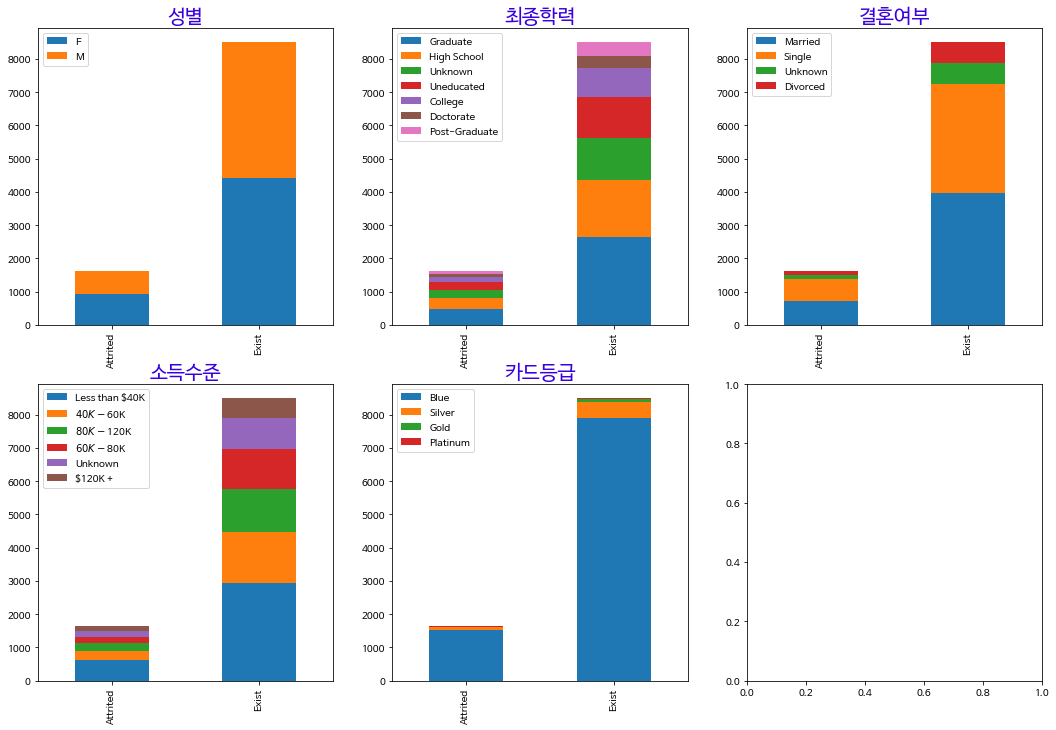

In [ ]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,12)


bar_chart('Gender', ax1)
bar_chart('Education_Level', ax2)
bar_chart('Marital_Status', ax3)
bar_chart('Income_Category', ax4)
bar_chart('Card_Category', ax5)

# ax1.set(title="성별")
ax1.set_title('성별', color='#3A01DF', fontsize =20)
ax2.set_title('최종학력', color='#3A01DF', fontsize =20)
ax3.set_title('결혼여부', color='#3A01DF', fontsize =20)
ax4.set_title('소득수준', color='#3A01DF', fontsize =20)
ax5.set_title('카드등급', color='#3A01DF', fontsize =20)

### <font color=yellow>Numerical Column</font>

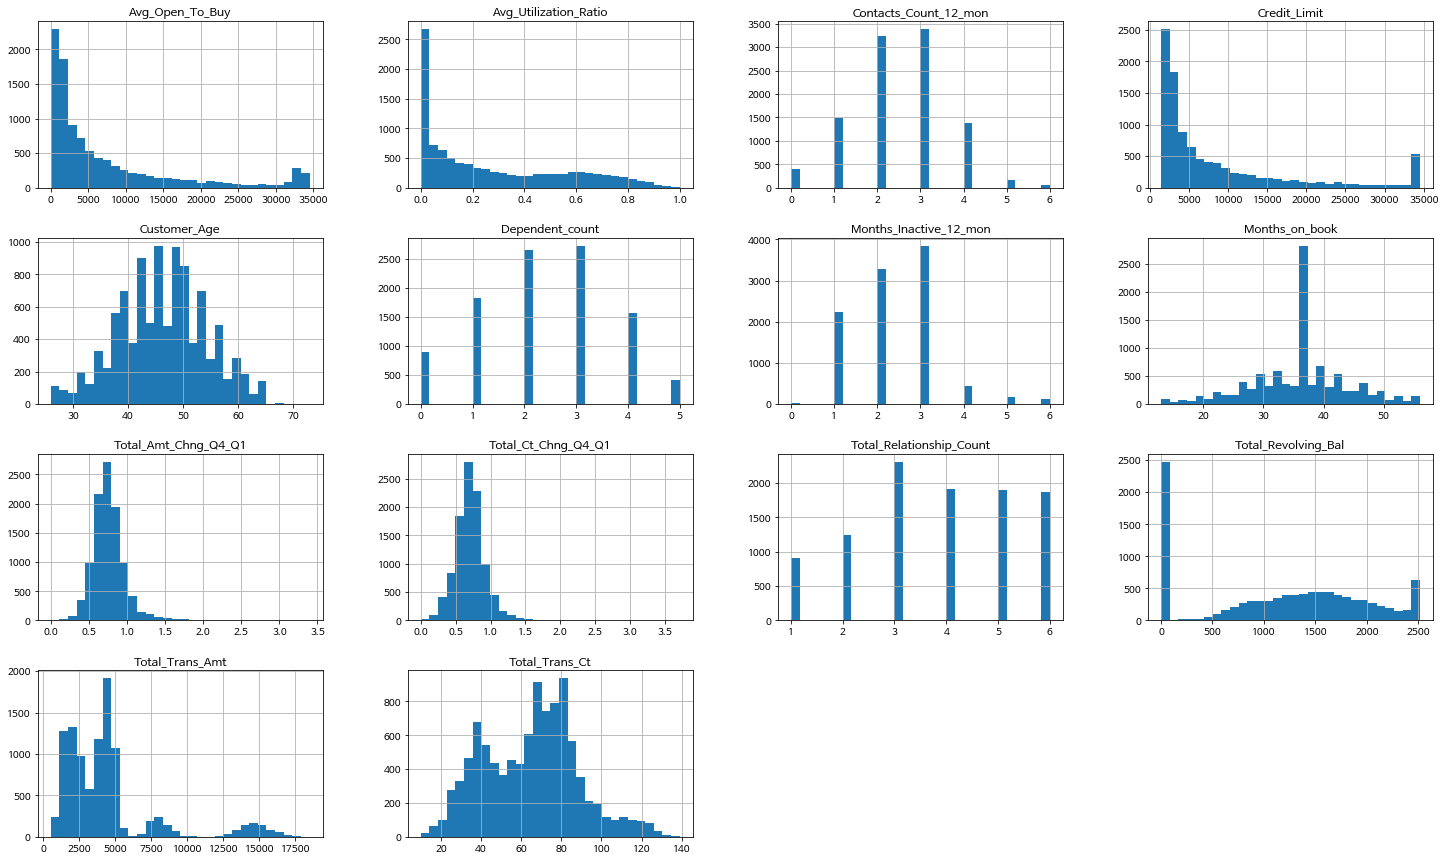

In [ ]:
df_num = df[num_col]
df_num.hist(bins=30, figsize=(25,15) );

###  <font color=yellow>Target Column Distribution(Categorical)</font>

In [ ]:
data_explode = pd.read_csv('/content/BankChurners.csv')
data_explode.drop(data_explode.columns[-2:], axis=1, inplace=True) 
data_explode.drop(data_explode.columns[0], axis=1, inplace=True)

#Use stratified sampling to split the dataset
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10)

for train_index, test_index in split.split(data_explode, data_explode["Attrition_Flag"]):
    train_set = data_explode.loc[train_index]
    test_set = data_explode.loc[test_index]
    
target = 'Attrition_Flag'
train_set[target] = train_set[target].map({'Existing Customer':0, 'Attrited Customer':1})
test_set[target] = test_set[target].map({'Existing Customer':0, 'Attrited Customer':1})

churn = train_set.copy()

num_vars = list(churn.select_dtypes(include=[np.number]).columns)
cat_vars = list(churn.select_dtypes(include=['object']).columns)
num_vars.remove('Attrition_Flag')

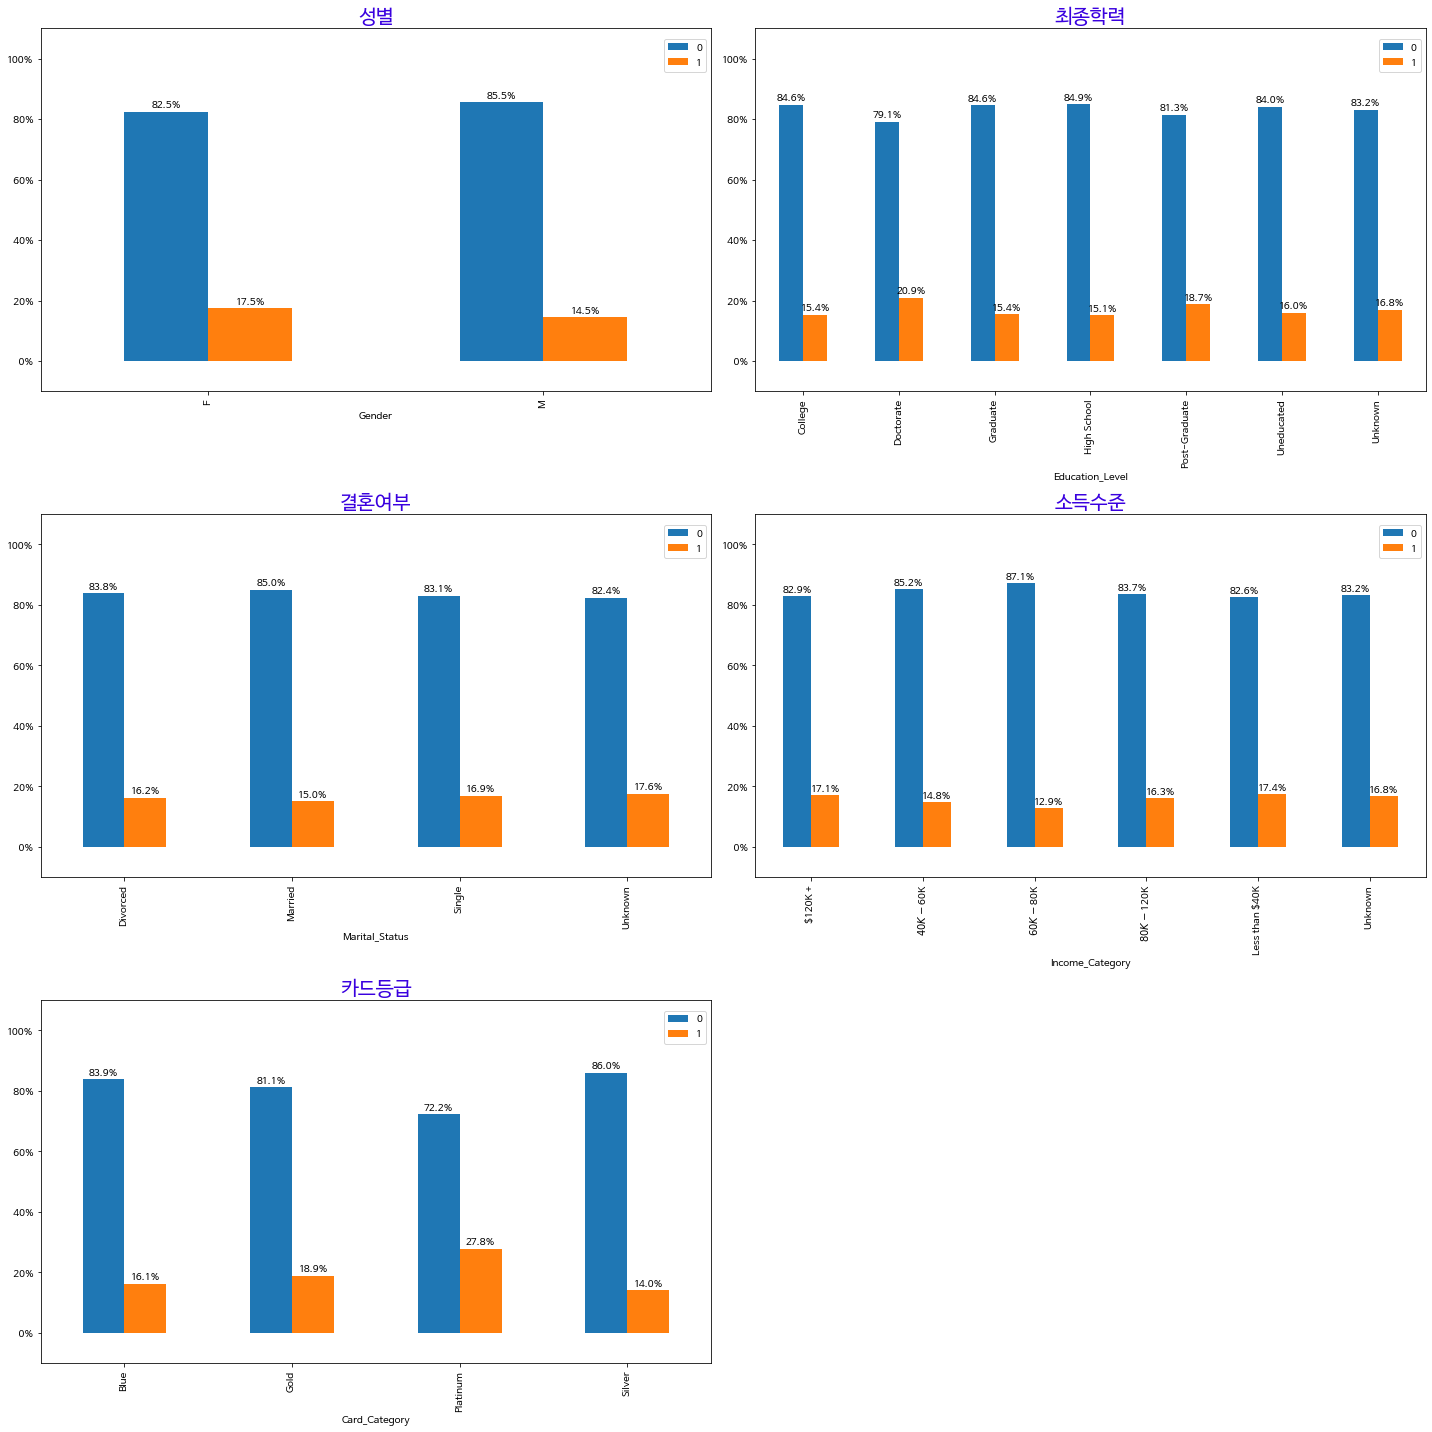

In [ ]:
def plt_hue_cat(df, cat, target='Attrition_Flag', title=None, ax=None):
    #Create crosstab
    table = pd.crosstab(index=df[cat], columns=churn[target], normalize='index')
    
    if ax==None:
        fig, ax = plt.subplots()
    table.plot.bar(ax=ax)
    
    max_height = max([p.get_height() for p in ax.patches])
    min_height = min([p.get_height() for p in ax.patches])
    
    for i,p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{table.unstack().iloc[i]:.1%}', (x + width/2, y+height+min_height*0.1), ha='center')
         
    
    ylim=max_height+max_height
    ax.set_ylim(-.1, 1.1)
    y_vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])
    
    
    if title==None:
        title=cat
        if title == 'Gender':
            title = '성별'
        elif title == 'Education_Level':
            title = '최종학력'
        elif title == 'Marital_Status':
            title = '결혼여부'
        elif title == 'Income_Category':
            title = '소득수준'
        else :
                title = '카드등급'
    ax.set_title(title, color='#3A01DF', fontsize =20)
    ax.legend(loc=(0.93,0.88))
    plt.tight_layout()
    
rows = len(cat_vars)//2+1
fig, axes = plt.subplots(rows, 2, figsize=(20,20))
axes = axes.ravel()
axes[-1].remove()

for i in range(len(cat_vars)):
    cat = cat_vars[i]
    plt_hue_cat(df=churn, cat=cat, ax=axes[i])

plt.show()


###  <font color=yellow>Target Column Distribution(Numerical)</font>

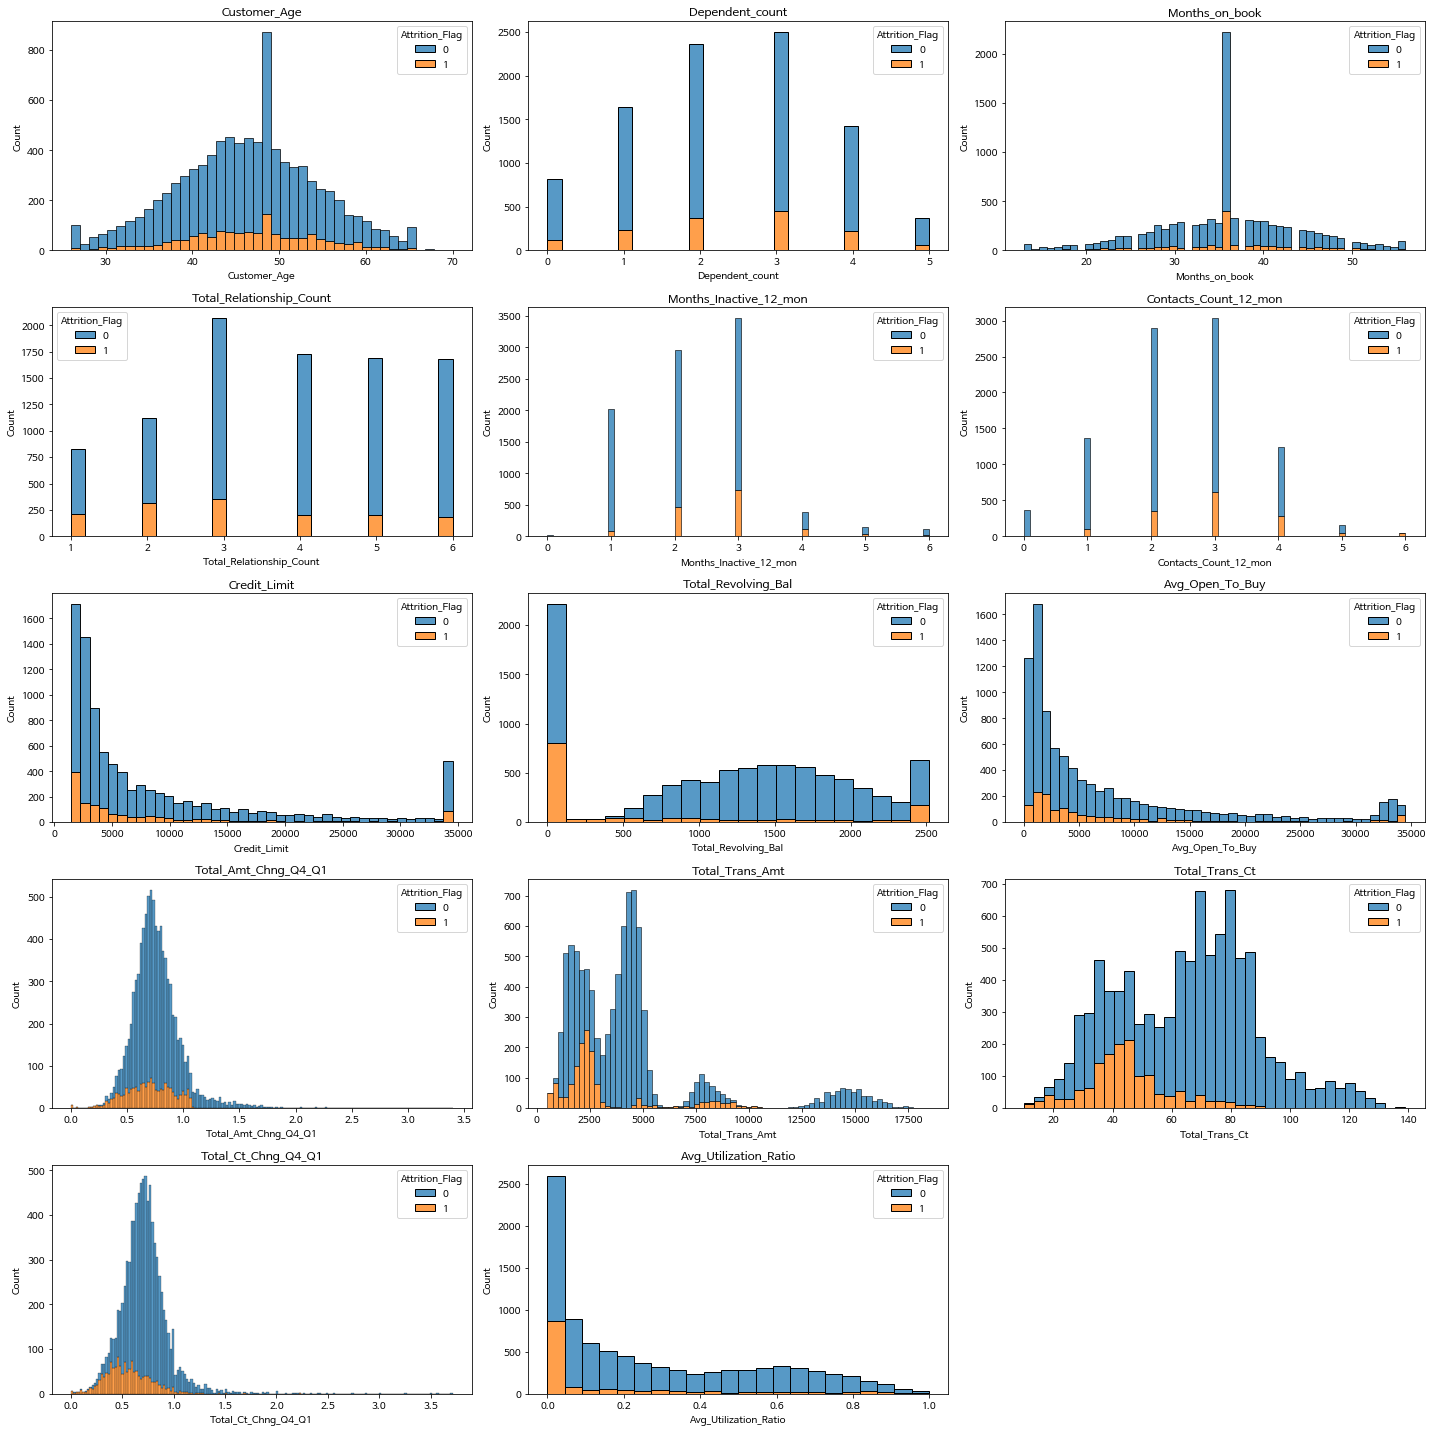

In [ ]:
def plt_hue_num(df, num_var, target='Attrition_Flag', title=None, ax=None):
    
    if ax==None:
        fig, ax = plt.subplots()
    
    sns.histplot(df, x=num_var, hue=target, ax=ax, multiple = 'stack')

    if title==None:
        title=num_var
        
    ax.set_title(title)
    plt.tight_layout()
    
rows = len(num_vars)//3+1
fig, axes = plt.subplots(rows, 3, figsize=(20,20))
axes = axes.ravel()
axes[-1].remove()

for i in range(len(num_vars)):
    num_var = num_vars[i]
    plt_hue_num(churn, num_var, target='Attrition_Flag', ax=axes[i])    
    plt.tight_layout()
     
plt.show()

# <font color=#cccccc>결측치 확인 / Feature engineering & Feature selection</font>

### <font color=yellow>결측치 처리 방법 1. 결측치 포함 행 삭제</font>

#### <font color=yellow>Preprocessing categorical data (text -> number)</font>

In [ ]:
# data_df = df.copy()

In [ ]:
# data_df[data_df.iloc[:,:] == 'Unknown'].count()

In [ ]:
# print(data_df['Education_Level'].value_counts())
# print()
# print(data_df['Marital_Status'].value_counts())
# print()
# print(data_df['Income_Category'].value_counts())

In [ ]:
# catg_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category'] #범주형데이터열

# # 결측치가 포함된 열을 알려주는 함수
# def hasUnknown(feature): 
#     result = 0
#     for x in data_df[feature].str.contains('Unknown'):
#         if x == True: #
#             result = 1
#     if result == 1:
#         print('{} : has string "Unknown"!'.format(feature))

# # Unknown문자열이 포함된 셀을 결측치(NaN)로 변형시키는 코드
# for feature in catg_features: 
#     hasUnknown(feature)
#     data_df.loc[data_df[feature] == 'Unknown', feature] = np.nan 

# data_df.info()

In [ ]:
# index_dicts = {}
# for cat_feature in catg_features:
#     data_df[cat_feature] = data_df[cat_feature].astype('category')
#     idx_list = dict(enumerate(data_df[cat_feature].cat.categories)) 
#     index_dicts[cat_feature] = idx_list
# index_dicts

In [ ]:
# # 문자열 카테고리를 index번호(카테고리번호)로 replace
# for cat_feature in catg_features:
#     for k,v in index_dicts[cat_feature].items():
#         data_df[cat_feature].replace(v,k, inplace=True) 

# # y 데이터 변환
# data_df.Attrition_Flag = data_df.Attrition_Flag.apply(lambda x: 1 if 'Existing' in x else 0)

#### <font color=yellow>결측치 제거</font>



In [ ]:
# #결측치 제거
# data_df.dropna(inplace=True)
# data_df.info()

In [ ]:
# # 결측치를 제거하며, 빠진 인덱스값을 재정의

# data_df = data_df.reset_index()
# del data_df['index']
# data_df.head()

In [ ]:
# #category int로 바꾸기 (pipeline이 category을 못알아먹음)
# for cat_feature in catg_features:
#     data_df[cat_feature] = data_df[cat_feature].astype(int)

### <font color=yellow>결측치 처리 방법 2. 결측치 채우기</font>

#### <font color=yellow>datawig(딥러닝모델) 사용</font>

In [ ]:
data_df = df.copy()

In [ ]:
catg_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category'] #범주형데이터열

features_with_nan = []

# 결측치가 포함된 열을 알려주는 함수
def hasUnknown(feature): 
    result = 0
    for x in data_df[feature].str.contains('Unknown'):
        if x == True: #
            result = 1
    if result == 1:
        print('{} : has string "Unknown"!'.format(feature))
        features_with_nan.append(feature)

# Unknown문자열이 포함된 셀을 결측치(NaN)로 변형시키는 코드
for feature in catg_features: 
    hasUnknown(feature)
    data_df.loc[data_df[feature] == 'Unknown', feature] = np.nan 

data_df.info()

Education_Level : has string "Unknown"!
Marital_Status : has string "Unknown"!
Income_Category : has string "Unknown"!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             8608 non-null object
Marital_Status              9378 non-null object
Income_Category             9015 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10

In [ ]:
# [장]범주형변수 결측치 예측에 뛰어난 성능을 보임 [단]오래 걸림...


for feature in features_with_nan:
  dtw_train = data_df[data_df[feature].notnull()]
  dtw_test = data_df[data_df[feature].isnull()]
      
  imputer_datawig = datawig.SimpleImputer(
      input_columns=list(data_df.columns.difference(features_with_nan)), # 결측치를 채우기 위해 참고하는 열
      output_column=feature # 채우려는 결측치 열
      )
  
  imputer_datawig.fit(train_df = dtw_train) # num_epochs=50 파라미터 추가 가능
  imputed = imputer_datawig.predict(dtw_test)
  data_df.loc[data_df[feature].isnull(),feature] = imputed['{}_imputed'.format(feature)]

2021-07-22 05:38:25,658 [INFO]  
========== start: fit model
2021-07-22 05:38:25,661 [WARNING]  Already bound, ignoring bind()
2021-07-22 05:38:30,894 [INFO]  Epoch[0] Batch [0-243]	Speed: 757.25 samples/sec	cross-entropy=1.547754	Education_Level-accuracy=0.335297
2021-07-22 05:38:35,963 [INFO]  Epoch[0] Train-cross-entropy=1.522612
2021-07-22 05:38:35,966 [INFO]  Epoch[0] Train-Education_Level-accuracy=0.351418
2021-07-22 05:38:35,972 [INFO]  Epoch[0] Time cost=10.306
2021-07-22 05:38:35,983 [INFO]  Saved checkpoint to "education_level/model-0000.params"
2021-07-22 05:38:36,843 [INFO]  Epoch[0] Validation-cross-entropy=1.509402
2021-07-22 05:38:36,846 [INFO]  Epoch[0] Validation-Education_Level-accuracy=0.362269
2021-07-22 05:38:41,985 [INFO]  Epoch[1] Batch [0-243]	Speed: 760.91 samples/sec	cross-entropy=1.522297	Education_Level-accuracy=0.342469
2021-07-22 05:38:47,037 [INFO]  Epoch[1] Train-cross-entropy=1.502672
2021-07-22 05:38:47,043 [INFO]  Epoch[1] Train-Education_Level-accura

In [ ]:
index_dicts = {}
for cat_feature in catg_features:
    data_df[cat_feature] = data_df[cat_feature].astype('category')
    idx_list = dict(enumerate(data_df[cat_feature].cat.categories)) 
    index_dicts[cat_feature] = idx_list
index_dicts

{'Card_Category': {0: 'Blue', 1: 'Gold', 2: 'Platinum', 3: 'Silver'},
 'Education_Level': {0: 'College',
  1: 'Doctorate',
  2: 'Graduate',
  3: 'High School',
  4: 'Post-Graduate',
  5: 'Uneducated'},
 'Gender': {0: 'F', 1: 'M'},
 'Income_Category': {0: '$120K +',
  1: '$40K - $60K',
  2: '$60K - $80K',
  3: '$80K - $120K',
  4: 'Less than $40K'},
 'Marital_Status': {0: 'Divorced', 1: 'Married', 2: 'Single'}}

In [ ]:
# 문자열 카테고리를 index번호(카테고리번호)로 replace
for cat_feature in catg_features:
    for k,v in index_dicts[cat_feature].items():
        data_df[cat_feature].replace(v,k, inplace=True) 

# y 데이터 변환
data_df.Attrition_Flag = data_df.Attrition_Flag.apply(lambda x: 1 if 'Existing' in x else 0)

In [ ]:
#category int로 바꾸기 (pipeline이 category을 못알아먹음)
for cat_feature in catg_features:
    data_df[cat_feature] = data_df[cat_feature].astype(int)

In [ ]:
data_df.to_csv('filled_df.csv')

In [ ]:
data_df = pd.read_csv('/content/filled_df.csv')

#### <font color=yellow>Use KNNImputer (Fail) </font>
참고) https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 

In [ ]:
# data_df = df.copy()

In [ ]:
# catg_features = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category'] #범주형데이터열

# # 결측치가 포함된 열을 알려주는 함수
# def hasUnknown(feature): 
#     result = 0
#     for x in data_df[feature].str.contains('Unknown'):
#         if x == True: #
#             result = 1
#     if result == 1:
#         print('{} : has string "Unknown"!'.format(feature))

# # Unknown문자열이 포함된 셀을 결측치(NaN)로 변형시키는 코드
# for feature in catg_features: 
#     hasUnknown(feature)
#     data_df.loc[data_df[feature] == 'Unknown', feature] = np.nan 

# data_df.info()

In [ ]:
# # 범주형 변수 열 카테고리에 자동으로 부여될 index를 담는 딕셔너리 생성 코드
# index_dicts = {}
# for cat_feature in catg_features:
#     data_df[cat_feature] = data_df[cat_feature].astype('category')
#     idx_list = dict(enumerate(data_df[cat_feature].cat.categories)) 
#     index_dicts[cat_feature] = idx_list
# index_dicts

In [ ]:
# # 문자열 카테고리를 index번호(카테고리번호)로 replace
# for cat_feature in catg_features:
#     for k,v in index_dicts[cat_feature].items():
#         data_df[cat_feature].replace(v,k, inplace=True) 

# # y 데이터 변환
# data_df.Attrition_Flag = data_df.Attrition_Flag.apply(lambda x: 1 if 'Existing' in x else 0)

In [ ]:
# # 방법 1) KNNImputer로 결측치 추가
# from sklearn.impute import KNNImputer

# imputer_KNN = KNNImputer(n_neighbors=30)
# df_filled_KNN = imputer_KNN.fit_transform(df)
# df_filled_KNN = pd.DataFrame(df_filled_KNN).round(decimals=0)
# df_filled_KNN.columns = df.columns
# df_filled_KNN.head()

In [ ]:
# #category int로 바꾸기 (pipeline이 category을 못알아먹음)
# for cat_feature in catg_features:
#     data_df[cat_feature] = data_df[cat_feature].astype(int)

<font color=#cccccc>correlation matrix</font>
==

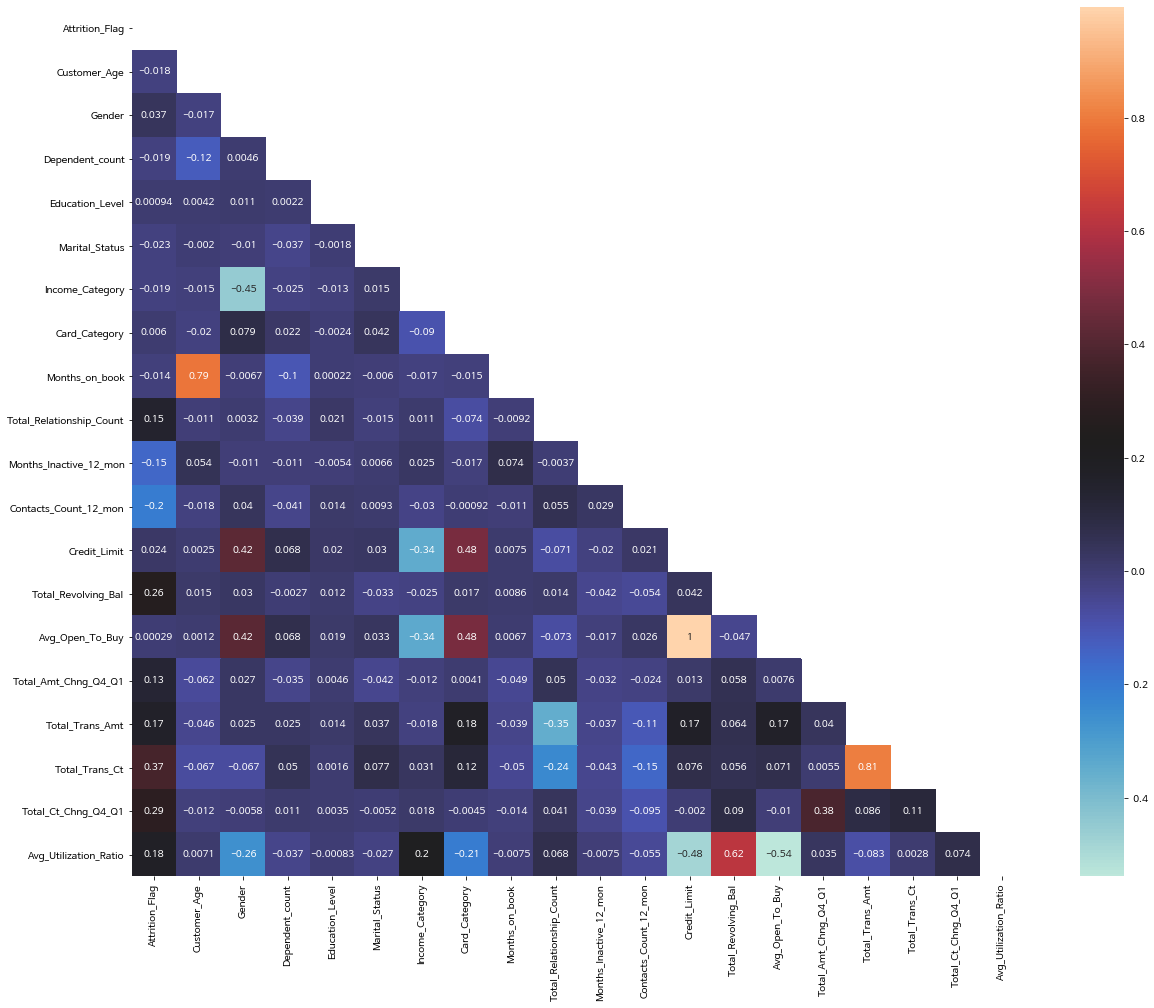

In [ ]:
fig, ax = plt.subplots(figsize=(20, 16))
df_corr = data_df.corr(method="pearson")
mask = np.zeros_like(np.array(df_corr))
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask=mask, annot=True, cmap='icefire')

#결측치도 채워진 상태이며, 크게 상관계수가 튄다고 생각되는 열이 없음 열삭제 없이 그냥 진행

<font color=#cccccc>데이터 분리</font>
==

In [ ]:
x_data = data_df.drop(['Attrition_Flag'], axis=1)
y_data = data_df['Attrition_Flag']

<font color=#cccccc>Train the model</font>
==

In [ ]:
x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

### <font color=yellow>Feature Scaling(Pipeline)</font>

In [ ]:
categorical_features = ['Card_Category', 'Education_Level', 'Gender', 'Income_Category', 'Marital_Status']
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

temp = list(data_df[data_df.columns.difference(categorical_features)].columns)
temp.remove('Attrition_Flag')

numeric_features = temp
numeric_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

preprocessor_pipe.fit(x_train)

x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

pd.DataFrame(x_train_transformed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.883937,-0.726172,0.486704,0.890409,0.070596,-0.268854,-1.323300,0.503428,-0.536527,-0.821786,1.414525,0.075773,-0.229879,-0.370894,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.436495,-0.050252,1.383209,-0.428937,0.949128,-1.040993,2.625985,1.512241,0.555353,0.010678,0.127801,0.081877,3.313302,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.596677,0.040598,0.486704,-0.634064,-0.682431,1.275424,-0.335979,-0.379283,0.771925,1.277828,0.771163,-0.417437,0.094497,0.525234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.341046,0.040598,-0.409802,-0.277293,0.196101,0.503285,-1.323300,0.377326,-0.820776,-0.231269,-0.515561,0.705715,-0.037308,-0.072185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.166221,-0.380944,-1.306308,-0.161304,0.321605,1.275424,-1.323300,0.629530,-0.464336,1.171207,-0.515561,0.053798,-0.336732,-0.285549,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,1.643015,-0.784316,0.486704,1.662825,-2.062980,-1.813132,0.651342,-2.018605,0.907282,0.129602,-1.802285,0.227154,2.563568,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7084,-0.411834,-0.460892,0.486704,-0.468994,0.447110,-0.268854,0.651342,0.881733,0.248544,0.035283,0.127801,-0.635963,-0.162949,0.695925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7085,0.156456,-0.384578,-2.202814,0.225399,1.702155,-1.040993,0.651342,1.764445,0.997520,0.818538,0.127801,0.765535,-0.086919,0.098506,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7086,2.813173,-0.835191,-0.409802,2.846484,0.572614,0.503285,0.651342,0.503428,0.013925,0.252626,-0.515561,0.382198,2.863286,2.317490,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
pipeline_features = [x for x in x_data.columns if x not in categorical_features] #x_data의 열들 중 범주형 데이터를 제외한 열들 리스트에 담기

categorical_features = ['Card_Category', 'Education_Level', 'Gender', 'Income_Category', 'Marital_Status']


for category in categorical_features: #범주형 데이터속 범주들을 하나씩 꺼내어 열들에 추가하기
  for i in list(df[category].value_counts().keys()):
      pipeline_features.append(i)  

#위에 pipeline이 categorical_features 리스트 순서대로 들어갔기 때문에 순서 그대로 뽑아낸 코드

for i in range(pipeline_features.count('Unknown')): #겹쳐진 Unknown들 제거
  pipeline_features.remove('Unknown')

x_train_transformed_df = pd.DataFrame(x_train_transformed) #x_train_transformed로 df 만들기

x_train_transformed_df.columns = pipeline_features #x_train_transformed_df의 열들 이름을 pipeline_features 리스트로 변경

x_train_transformed_df

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Blue,Silver,Gold,Platinum,Graduate,High School,Uneducated,College,Post-Graduate,Doctorate,F,M,Less than $40K,$40K - $60K,$80K - $120K,$60K - $80K,$120K +,Married,Single,Divorced
0,0.883937,-0.726172,0.486704,0.890409,0.070596,-0.268854,-1.323300,0.503428,-0.536527,-0.821786,1.414525,0.075773,-0.229879,-0.370894,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.436495,-0.050252,1.383209,-0.428937,0.949128,-1.040993,2.625985,1.512241,0.555353,0.010678,0.127801,0.081877,3.313302,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.596677,0.040598,0.486704,-0.634064,-0.682431,1.275424,-0.335979,-0.379283,0.771925,1.277828,0.771163,-0.417437,0.094497,0.525234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.341046,0.040598,-0.409802,-0.277293,0.196101,0.503285,-1.323300,0.377326,-0.820776,-0.231269,-0.515561,0.705715,-0.037308,-0.072185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.166221,-0.380944,-1.306308,-0.161304,0.321605,1.275424,-1.323300,0.629530,-0.464336,1.171207,-0.515561,0.053798,-0.336732,-0.285549,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,1.643015,-0.784316,0.486704,1.662825,-2.062980,-1.813132,0.651342,-2.018605,0.907282,0.129602,-1.802285,0.227154,2.563568,1.634726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7084,-0.411834,-0.460892,0.486704,-0.468994,0.447110,-0.268854,0.651342,0.881733,0.248544,0.035283,0.127801,-0.635963,-0.162949,0.695925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7085,0.156456,-0.384578,-2.202814,0.225399,1.702155,-1.040993,0.651342,1.764445,0.997520,0.818538,0.127801,0.765535,-0.086919,0.098506,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7086,2.813173,-0.835191,-0.409802,2.846484,0.572614,0.503285,0.651342,0.503428,0.013925,0.252626,-0.515561,0.382198,2.863286,2.317490,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### <font color=yellow>LogisticRegression</font>

In [ ]:
clf_LR = LogisticRegression(random_state=0)
clf_LR.fit(x_train_transformed, y_train)
clf_LR_pred=clf_LR.predict(x_test_transformed)

print('accuracy: %.4f' % accuracy_score(y_test, clf_LR_pred))
print('precision: %.4f' % precision_score(y_test, clf_LR_pred))
print('recall: %.4f' % recall_score(y_test, clf_LR_pred))
print('F1: %.4f' % f1_score(y_test, clf_LR_pred))

accuracy: 0.9039
precision: 0.9324
recall: 0.9563
F1: 0.9442


### <font color=yellow>XGBClassifier</font>

In [ ]:
clf_XGB = XGBClassifier(random_state=0)
clf_XGB.fit(x_train_transformed, y_train)
clf_XGB_pred=clf_XGB.predict(x_test_transformed)

print('accuracy: %.4f' % accuracy_score(y_test, clf_XGB_pred))
print('precision: %.4f' % precision_score(y_test, clf_XGB_pred))
print('recall: %.4f' % recall_score(y_test, clf_XGB_pred))
print('F1: %.4f' % f1_score(y_test, clf_XGB_pred))

accuracy: 0.9658
precision: 0.9708
recall: 0.9895
F1: 0.9801


### <font color=yellow>LGBMClassifier</font>

In [ ]:
clf_LGBM = LGBMClassifier(random_state=0)
clf_LGBM.fit(x_train_transformed, y_train)
clf_LGBM_pred=clf_LGBM.predict(x_test_transformed)

print('accuracy: %.4f' % accuracy_score(y_test, clf_LGBM_pred))
print('precision: %.4f' % precision_score(y_test, clf_LGBM_pred))
print('recall: %.4f' % recall_score(y_test, clf_LGBM_pred))
print('F1: %.4f' % f1_score(y_test, clf_LGBM_pred))

accuracy: 0.9720
precision: 0.9771
recall: 0.9903
F1: 0.9837


### <font color=yellow>confusion_matrix</font>

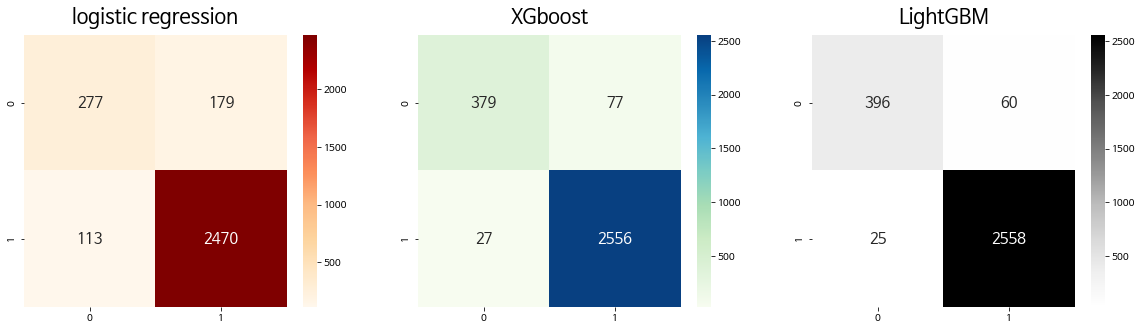

In [ ]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_LR_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_XGB_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_LGBM_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboost',pad = 12, fontsize = 20)
ax[2].set_title('LightGBM',pad = 12, fontsize = 20)
plt.show()

### <font color=yellow>get important features</font>

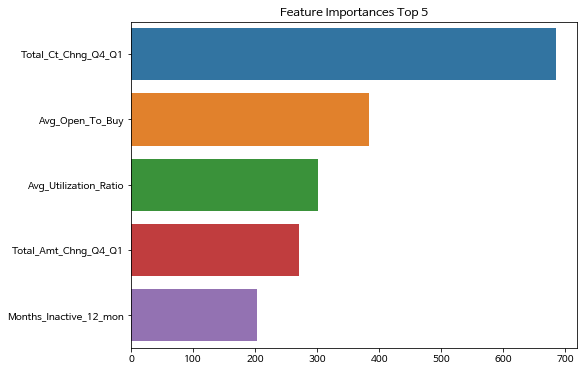

In [ ]:
feature_importance_values = clf_LGBM.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train_transformed_df.columns)
# 중요도값 순으로 Series를 정렬
feature_top20 = feature_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()

<font color=#cccccc>Rebalancing Samples</font>
==

### <font color=yellow>Resampling train-data</font>

In [ ]:
# Random Oversampling
over_x_train, over_y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(x_train, y_train)

# SMOTE
smote_x_train, smote_y_train = SMOTE().fit_resample(x_train,y_train)

# Boderline-SMOTE
bdlsmote_x_train, bdlsmote_y_train = BorderlineSMOTE().fit_resample(x_train, y_train)

# Boderline-SMOTE SVM
bdlSVMsmote_x_train, bdlSVMsmote_y_train = SVMSMOTE().fit_resample(x_train, y_train)

# ADASYN
adasyn_x_train, adasyn_y_train = ADASYN().fit_resample(x_train, y_train)

# SMOTE-TomekLinks
smotetomek_x_train, smotetomek_y_train = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')).fit_resample(x_train, y_train)

# SMOTE-ENN
smoteenn_x_train, smoteenn_y_train = SMOTEENN().fit_resample(x_train, y_train)


# StratifiedShuffleSplit (계층적 샘플링 시도)
split = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
# StratifiedShuffleSplit의 메소드 split로 train, test를 분할할 index 생성
for train_index, test_index in split.split(x_data, y_data):
    sss_x_train, sss_x_test = x_data.loc[train_index], x_data.loc[test_index]
    sss_y_train, sss_y_test = y_data.loc[train_index], y_data.loc[test_index]

### <font color=yellow>Resampling result</font>

In [ ]:
# Random Oversampling
print("Random Oversampling\n", over_y_train.value_counts())
# SMOTE
print("SMOTE\n", smote_y_train.value_counts())
# Boderline-SMOTE
print("Borderline-SMOTE\n", bdlsmote_y_train.value_counts())
# Boderline-SMOTE SVM
print("Borderline-SMOTE SVM\n", bdlSVMsmote_y_train.value_counts())
# ADASYN
print("ADASYN\n", adasyn_y_train.value_counts())
# SMOTE-TomekLinks
print("SMOTE-TomekLinks\n", smotetomek_y_train.value_counts())
# SMOTE-ENN
print("SMOTE-ENN\n", smoteenn_y_train.value_counts())
# StratifiedShuffleSplit의
print("StratifiedShuffleSplit의\n", sss_y_train.value_counts())

Random Oversampling
 1    5917
0    5917
Name: Attrition_Flag, dtype: int64
SMOTE
 1    5917
0    5917
Name: Attrition_Flag, dtype: int64
Borderline-SMOTE
 1    5917
0    5917
Name: Attrition_Flag, dtype: int64
Borderline-SMOTE SVM
 1    5917
0    5917
Name: Attrition_Flag, dtype: int64
ADASYN
 1    5917
0    5916
Name: Attrition_Flag, dtype: int64
SMOTE-TomekLinks
 1    5917
0    5743
Name: Attrition_Flag, dtype: int64
SMOTE-ENN
 0    4958
1    4696
Name: Attrition_Flag, dtype: int64
StratifiedShuffleSplit의
 1    5949
0    1139
Name: Attrition_Flag, dtype: int64


### <font color=yellow>Resampling result Visualize</font>

In [ ]:
datasets = [x_train_transformed, y_train, over_x_train, over_y_train, smote_x_train, smote_y_train,
            bdlsmote_x_train, bdlsmote_y_train, bdlSVMsmote_x_train, bdlSVMsmote_y_train, 
            adasyn_x_train, adasyn_y_train, smotetomek_x_train, smotetomek_y_train, 
            smoteenn_x_train, smoteenn_y_train, sss_x_train, sss_y_train]

for dataset in datasets:
    pd.DataFrame(dataset)

In [ ]:
train_concat = pd.concat([x_train, y_train], axis=1)
over_train_concat = pd.concat([over_x_train, over_y_train], axis=1)
smote_train_concat = pd.concat([smote_x_train, smote_y_train], axis=1)
bdlsmote_train_concat = pd.concat([bdlsmote_x_train, bdlsmote_y_train], axis=1)
bdlSVMsmote_train_concat = pd.concat([bdlSVMsmote_x_train, bdlSVMsmote_y_train], axis=1)
adasyn_train_concat = pd.concat([adasyn_x_train, adasyn_y_train], axis=1)
smotetomek_train_concat = pd.concat([smotetomek_x_train, smotetomek_y_train], axis=1)
smoteenn_train_concat = pd.concat([smoteenn_x_train, smoteenn_y_train], axis=1)
stratifiedshufflesplit_train_concat = pd.concat([sss_x_train, sss_y_train], axis=1)

Text(0.5, 1.0, 'StratifiedShuffleSplit')

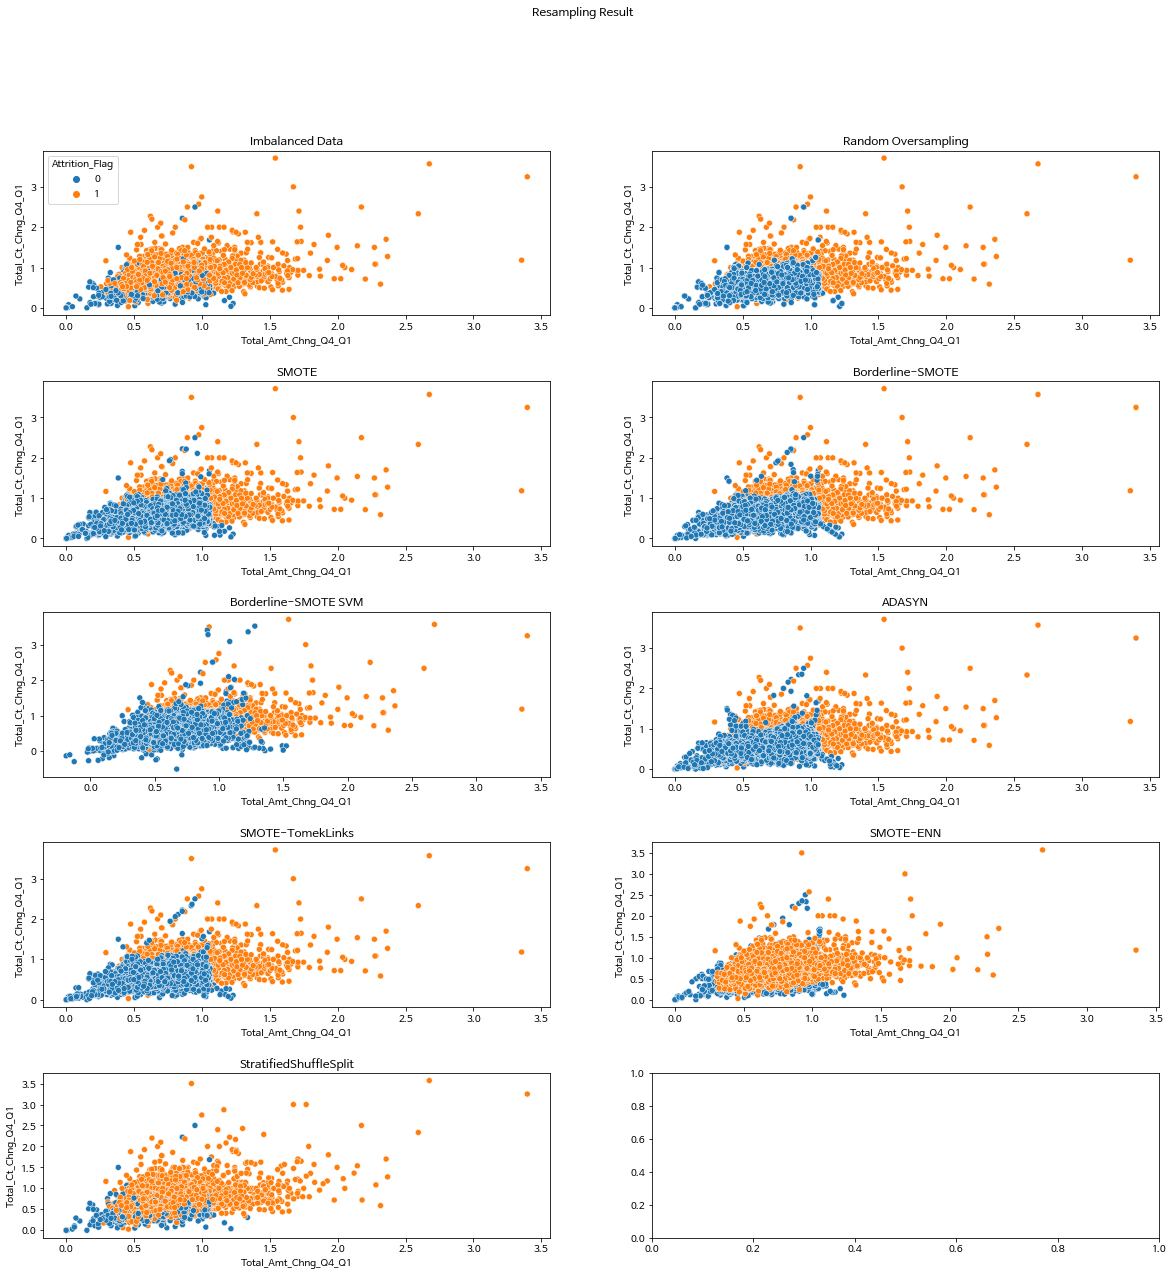

In [ ]:
# Visualize resampling results
fig, axes = plt.subplots(5, 2, figsize=(20, 20),squeeze=True)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
fig.suptitle('Resampling Result')

sns.scatterplot(ax=axes[0, 0], data=train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag')
sns.scatterplot(ax=axes[0, 1], data=over_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag', legend=False)
sns.scatterplot(ax=axes[1, 0], data=smote_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[1, 1], data=bdlsmote_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[2, 0], data=bdlSVMsmote_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[2, 1], data=adasyn_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[3, 0], data=smotetomek_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[3, 1], data=smoteenn_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)
sns.scatterplot(ax=axes[4, 0], data=stratifiedshufflesplit_train_concat, x='Total_Amt_Chng_Q4_Q1', y='Total_Ct_Chng_Q4_Q1', hue='Attrition_Flag',legend=False)

axes[0, 0].set_title("Imbalanced Data")
axes[0, 1].set_title("Random Oversampling")
axes[1, 0].set_title("SMOTE")
axes[1, 1].set_title("Borderline-SMOTE")
axes[2, 0].set_title("Borderline-SMOTE SVM")
axes[2, 1].set_title("ADASYN")
axes[3, 0].set_title("SMOTE-TomekLinks")
axes[3, 1].set_title("SMOTE-ENN")
axes[4, 0].set_title("StratifiedShuffleSplit")

<font color=#cccccc>Re_Train the model</font>
==

### <font color=yellow>LogisticRegression</font>

In [ ]:
x_train_transformed_resample = preprocessor_pipe.transform(over_x_train)
x_test_transformed_resample = preprocessor_pipe.transform(x_test)

In [ ]:
clf_LR2 = LogisticRegression(random_state=0)
clf_LR2.fit(x_train_transformed_resample, over_y_train)
clf_LR2_pred=clf_LR2.predict(x_test_transformed_resample)

print('accuracy: %.4f' % accuracy_score(y_test, clf_LR_pred))
print('precision: %.4f' % precision_score(y_test, clf_LR_pred))
print('recall: %.4f' % recall_score(y_test, clf_LR_pred))
print('F1: %.4f' % f1_score(y_test, clf_LR_pred))

accuracy: 0.9039
precision: 0.9324
recall: 0.9563
F1: 0.9442


### <font color=yellow>XGBClassifier</font>

In [ ]:
clf_XGB2 = XGBClassifier(random_state=0)
clf_XGB2.fit(x_train_transformed_resample, over_y_train)
clf_XGB2_pred=clf_XGB2.predict(x_test_transformed_resample)

print('accuracy: %.4f' % accuracy_score(y_test, clf_XGB2_pred))
print('precision: %.4f' % precision_score(y_test, clf_XGB2.predict(x_test_transformed)))
print('recall: %.4f' % recall_score(y_test, clf_XGB2.predict(x_test_transformed)))
print('F1: %.4f' % f1_score(y_test, clf_XGB2.predict(x_test_transformed)))

accuracy: 0.9500
precision: 0.9880
recall: 0.9528
F1: 0.9700


### <font color=yellow>LGBMClassifier</font>

In [ ]:
clf_LGBM2 = LGBMClassifier(random_state=0)
clf_LGBM2.fit(x_train_transformed_resample, over_y_train)
clf_LGBM2_pred=clf_LGBM2.predict(x_test_transformed_resample)

print('accuracy: %.4f' % accuracy_score(y_test, clf_LGBM2_pred))
print('precision: %.4f' % precision_score(y_test, clf_LGBM2.predict(x_test_transformed)))
print('recall: %.4f' % recall_score(y_test, clf_LGBM2.predict(x_test_transformed)))
print('F1: %.4f' % f1_score(y_test, clf_LGBM2.predict(x_test_transformed)))

accuracy: 0.9691
precision: 0.9852
recall: 0.9783
F1: 0.9817


### <font color=yellow>confusion_matrix</font>

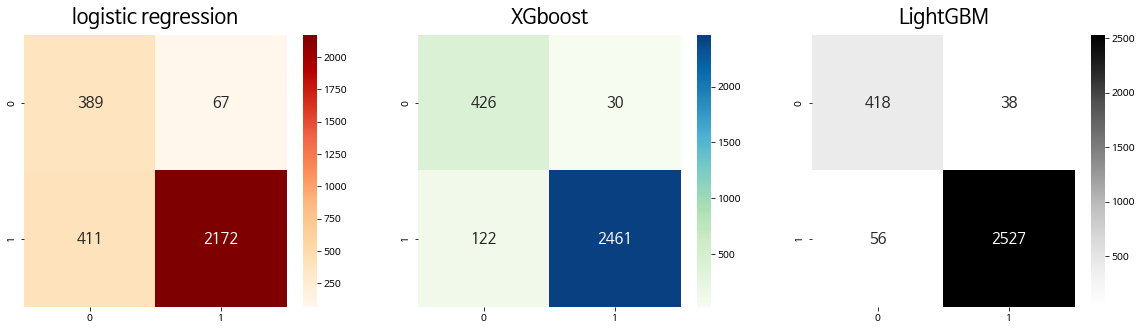

In [ ]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_LR2_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_XGB2_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_LGBM2_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboost',pad = 12, fontsize = 20)
ax[2].set_title('LightGBM',pad = 12, fontsize = 20)
plt.show()

<font color=#cccccc> Model stacking</font>
==

In [ ]:
stacking_models = [ LogisticRegression(random_state=0),
           XGBClassifier(random_state=0),
           LGBMClassifier(random_state=0)] 

In [ ]:
S_train, S_test = stacking(stacking_models, 
                           x_train_transformed_resample, over_y_train, x_test_transformed_resample, 
                           regression = False, 
                           metric = accuracy_score, 
                           n_folds = 4, stratified = True, shuffle = True, 
                           random_state = 0, verbose = 0) 

In [ ]:
pd.DataFrame(S_train)
clf_STACK = LGBMClassifier(seed = 0, \
                               n_jobs = -1,\
                               learning_rate = 0.08,\
                               n_estimators = 70,\
                               max_depth = 3)
clf_STACK = clf_STACK.fit(S_train, over_y_train)
clf_STACK_pred = clf_STACK.predict_proba(S_test) 
print('Final prediction score: [%.4f]' % accuracy_score(y_test, clf_LGBM2.predict(x_test_transformed_resample)))

Final prediction score: [0.9691]



<font color=#cccccc>AUC score of other model</font>
==

In [ ]:
instance_models = {"K-Nearest Neighbors   ": KNeighborsClassifier(),
          "Support Vector Machine": SVC(probability=True),
          "Decision Tree         ": DecisionTreeClassifier(),
          "Random Forest         ": RandomForestClassifier(),
          "Ada Boost             ": AdaBoostClassifier(),}

### <font color=yellow>Random Oversampling</font>

In [ ]:
over_x_train_resample = preprocessor_pipe.transform(over_x_train)

# Fit the instance_models: Oversampling
for name, model in instance_models.items():
    model.fit(over_x_train_resample, over_y_train)

# Print AUC score
print("Random Oversampling: AUC score")
for name, model in instance_models.items():
    print(name + ": {:.3f}".format(roc_auc_score(y_test, model.predict(x_test_transformed))))

Random Oversampling: AUC score
K-Nearest Neighbors   : 0.834
Support Vector Machine: 0.905
Decision Tree         : 0.874
Random Forest         : 0.897
Ada Boost             : 0.934


### <font color=yellow>SMOTE</font>

In [ ]:
smote_x_train_resample = preprocessor_pipe.transform(smote_x_train)

# Fit the instance_models: Oversampling
for name, model in instance_models.items():
    model.fit(smote_x_train_resample, smote_y_train)

# Print AUC score
print("SMOTE: AUC score")
for name, model in instance_models.items():
    print(name + ": {:.3f}".format(roc_auc_score(y_test, model.predict(x_test_transformed))))

SMOTE: AUC score
K-Nearest Neighbors   : 0.842
Support Vector Machine: 0.887
Decision Tree         : 0.877
Random Forest         : 0.911
Ada Boost             : 0.924


### <font color=yellow>Borderline-SMOTE</font>

In [ ]:
bdlsmote_x_train_resample = preprocessor_pipe.transform(bdlsmote_x_train)

# Fit the instance_models: Borderline-SMOTE
for name, model in instance_models.items():
    model.fit(bdlsmote_x_train_resample, bdlsmote_y_train)

# Print AUC score
print("Borderline-SMOTE: AUC score")
for name, model in instance_models.items():
    print(name + ": {:.3f}".format(roc_auc_score(y_test, model.predict(x_test_transformed))))

Borderline-SMOTE: AUC score
K-Nearest Neighbors   : 0.830
Support Vector Machine: 0.885
Decision Tree         : 0.883
Random Forest         : 0.902
Ada Boost             : 0.921


# <font>Hyper parameter optimize</font>

In [ ]:
parameters = {'max_depth':[2,3,5,10,15,20],\
             'n_estimators':[100,70,50,30,20,10,5],\
              'learning_rate':[0.1,0.05,0.08]}

grid_LGBM = GridSearchCV(clf_LGBM2 , param_grid=parameters , scoring='accuracy',\
                        cv=5, refit=True)
grid_LGBM.fit(x_train_transformed_resample, over_y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_LGBM.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_LGBM.best_score_))
best_LGBM = grid_LGBM.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_LGBM.predict(x_test_transformed_resample)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 LGBMClassifier 정확도 : {0:.4f}'.format(accuracy))

df_LGBM = pd.DataFrame(grid_LGBM.cv_results_)
pd.set_option('display.max.colwidth', 200)
df_LGBM[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]\
.sort_values('rank_test_score').head(10)

GridSearchCV 최적 하이퍼 파라미터 : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
GridSearchCV 최고 정확도: 0.9879
테스트 세트에서의 LGBMClassifier 정확도 : 0.9717


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
21,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}",0.987916,1,0.986903,0.986058,0.989016
35,"{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}",0.987325,2,0.986903,0.986058,0.988171
28,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}",0.987156,3,0.986903,0.986481,0.987748
105,"{'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 100}",0.986142,4,0.986058,0.984791,0.986903
119,"{'learning_rate': 0.08, 'max_depth': 20, 'n_estimators': 100}",0.986057,5,0.984791,0.984368,0.986903
112,"{'learning_rate': 0.08, 'max_depth': 15, 'n_estimators': 100}",0.985973,6,0.984368,0.984791,0.986903
22,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 70}",0.985212,7,0.983101,0.982678,0.988171
36,"{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 70}",0.984367,8,0.984791,0.982256,0.984791
29,"{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 70}",0.984198,9,0.982256,0.982256,0.985636
14,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}",0.983100,10,0.981834,0.981411,0.986481


# <font>Auto ML (새로운 주피터 파일에서 열기)</font>

# <font color=#cccccc>DL Model 적용</font>

### <font color=yellow>Library Import</font>

In [ ]:
print(x_train_transformed_resample.shape)
print(over_y_train.shape)
print(x_test_transformed_resample.shape)
print(y_test.shape)

y_test = y_test.values.reshape(-1,1)
over_y_train = over_y_train.values.reshape(-1,1)
print('===========y data 2차원으로 변환==============')
print(x_train_transformed_resample.shape)
print(over_y_train.shape)
print(x_test_transformed_resample.shape)
print(y_test.shape)

(11834, 34)
(11834,)
(3039, 34)
(3039,)
===========y data 2차원으로 변환==============
(11834, 34)
(11834, 1)
(3039, 34)
(3039, 1)


### <font color=yellow>1st_elu_hidden layer3_Dropout</font>

In [ ]:
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(over_y_train).toarray()
test_label = enc.fit_transform(y_test).toarray()

print(train_label.shape)
print(test_label.shape) 


model = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=34, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output



model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])


history = model.fit(x_train_transformed_resample, train_label, batch_size=100, epochs=20, validation_split=0.3) 

(11834, 2)
(3039, 2)
Epoch 1/20
83/83 [==============================] - 2s 17ms/step - loss: 0.4639 - categorical_accuracy: 0.8523 - val_loss: 0.3466 - val_categorical_accuracy: 0.8631
Epoch 2/20
83/83 [==============================] - 1s 14ms/step - loss: 0.2419 - categorical_accuracy: 0.9047 - val_loss: 0.2977 - val_categorical_accuracy: 0.8736
Epoch 3/20
83/83 [==============================] - 1s 14ms/step - loss: 0.2065 - categorical_accuracy: 0.9190 - val_loss: 0.2195 - val_categorical_accuracy: 0.9062
Epoch 4/20
83/83 [==============================] - 1s 14ms/step - loss: 0.1832 - categorical_accuracy: 0.9264 - val_loss: 0.2140 - val_categorical_accuracy: 0.9240
Epoch 5/20
83/83 [==============================] - 1s 14ms/step - loss: 0.1607 - categorical_accuracy: 0.9348 - val_loss: 0.1551 - val_categorical_accuracy: 0.9358
Epoch 6/20
83/83 [==============================] - 1s 13ms/step - loss: 0.1376 - categorical_accuracy: 0.9433 - val_loss: 0.1847 - val_categorical_accura

In [ ]:
result = model.evaluate(x_test_transformed_resample, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

95/95 [==============================] - 0s 3ms/step - loss: 0.2502 - categorical_accuracy: 0.9388
loss (cross-entropy) : 0.2502250075340271
test accuracy : 0.9387956857681274


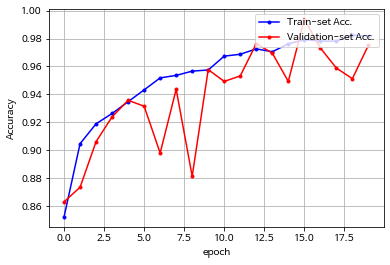

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

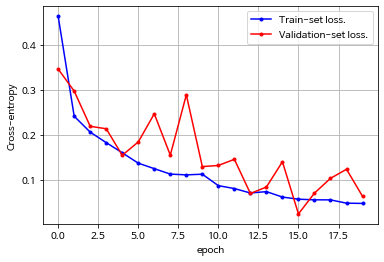

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

### <font color=yellow>2nd_relu_hidden layer1_Dropout</font>

In [ ]:
model_over_relu_R = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model_over_relu_R.add(layers.Dense(input_dim=34, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model_over_relu_R.add(layers.Activation('relu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model_over_relu_R.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model_over_relu_R.add(layers.Activation('relu')) 

model_over_relu_R.add(layers.Dropout(rate=0.2)) # Dropout-layer

model_over_relu_R.add(layers.Dense(units=2, activation='softmax')) 

model_over_relu_R.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer, Adam(학습률)
              loss=losses.binary_crossentropy, 
              metrics=[tf.keras.metrics.Recall()])

history_rec = model_over_relu_R.fit(x_train_transformed_resample, train_label, batch_size=10, epochs=20, validation_split=0.3) 

Epoch 1/20
829/829 [==============================] - 3s 3ms/step - loss: 0.2742 - recall: 0.8898 - val_loss: 0.3504 - val_recall: 0.8420
Epoch 2/20
829/829 [==============================] - 2s 3ms/step - loss: 0.1855 - recall: 0.9258 - val_loss: 0.2612 - val_recall: 0.8848
Epoch 3/20
829/829 [==============================] - 2s 3ms/step - loss: 0.1493 - recall: 0.9428 - val_loss: 0.2832 - val_recall: 0.8890
Epoch 4/20
829/829 [==============================] - 2s 3ms/step - loss: 0.1238 - recall: 0.9505 - val_loss: 0.1767 - val_recall: 0.9302
Epoch 5/20
829/829 [==============================] - 2s 3ms/step - loss: 0.1062 - recall: 0.9598 - val_loss: 0.2477 - val_recall: 0.9012
Epoch 6/20
829/829 [==============================] - 2s 3ms/step - loss: 0.0901 - recall: 0.9669 - val_loss: 0.1640 - val_recall: 0.9310
Epoch 7/20
829/829 [==============================] - 2s 3ms/step - loss: 0.0815 - recall: 0.9701 - val_loss: 0.1196 - val_recall: 0.9592
Epoch 8/20
829/829 [==============

In [ ]:
result = model_over_relu_R.evaluate(x_test_transformed_resample, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

95/95 [==============================] - 0s 1ms/step - loss: 0.3658 - recall: 0.9296
loss (cross-entropy) : 0.3658270239830017
test accuracy : 0.9295821189880371


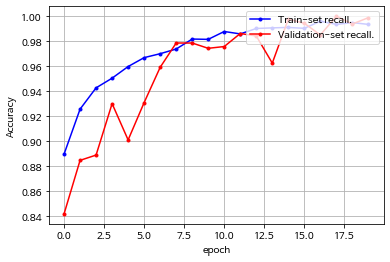

In [ ]:
acc = history_rec.history['recall']
val_acc = history_rec.history['val_recall']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set recall.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set recall.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

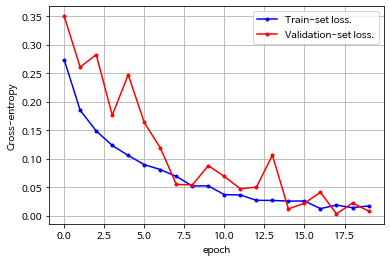

In [ ]:
loss = history_rec.history['loss']
val_loss = history_rec.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# <font>Keras tuner (새로운 주피터 파일에서 열기)</font>